In [17]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

%matplotlib inline

## Exploring with the Lemmatizer

**Create Documents**

In [4]:
cats = ['art', 'gaming', 'music', 'politics_news', 'reading', 'science', 'sports', 'tech']
stem = 'lemma'

In [5]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [6]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])
documents[:, 2]

array(['0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '2', '2', '2',
       '2', '2', '3', '3', '3', '3', '4', '4', '4', '4', '4', '5', '5',
       '5', '5', '5', '6', '6', '6', '6', '7', '7', '7', '7', '7'],
      dtype='<U1716906')

In [7]:
encoder.inverse_transform(np.array(documents[:, 2], dtype=int))

array(['art', 'art', 'art', 'art', 'art', 'gaming', 'gaming', 'gaming',
       'gaming', 'gaming', 'music', 'music', 'music', 'music', 'music',
       'politics_news', 'politics_news', 'politics_news', 'politics_news',
       'reading', 'reading', 'reading', 'reading', 'reading', 'science',
       'science', 'science', 'science', 'science', 'sports', 'sports',
       'sports', 'sports', 'tech', 'tech', 'tech', 'tech', 'tech'],
      dtype='<U1716906')

**Create Document Vectors**

We should explore using both the tfidf- and count-vectorizers; we should also look at different combinations of ngrams (let's use 1-grams, 1- and 2-grams, and 1- and 2- and 3-grams).

**TF-IDF Vectorizer**

Let's start by just looking at 1-grams:

In [6]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

In [19]:
def get_label(i, colors, documents):
    if colors[documents[i][1]][1] == 0:
        colors[documents[i][1]][1] += 1
        return documents[i][1]
    else:
        return ""

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

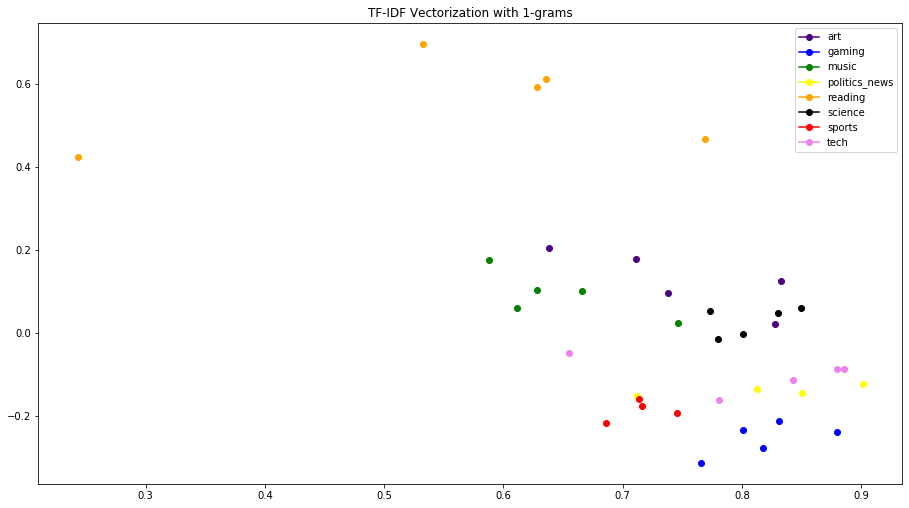

In [8]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

And now for 1- and 2-grams:

In [9]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1- and 2-grams')

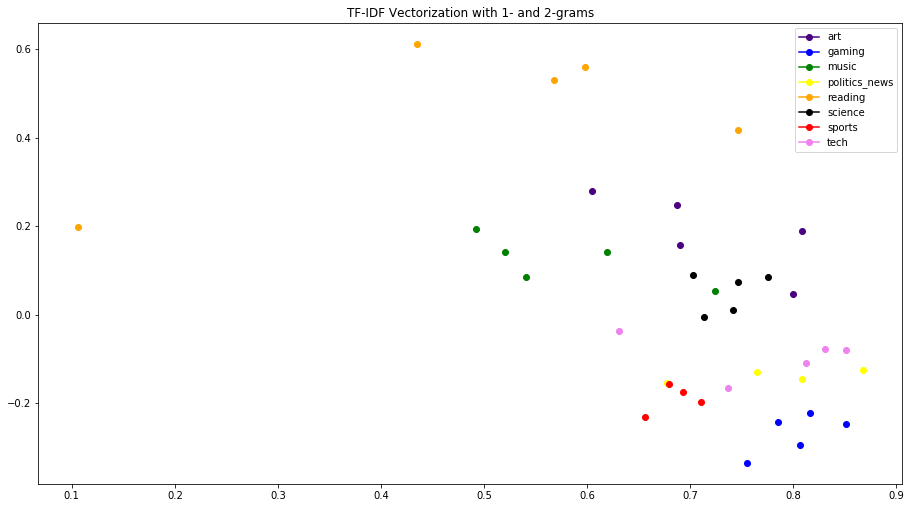

In [10]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1- and 2-grams')

And now finally with 1-, 2-, and 3-grams:

In [11]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-, 2-, and 3-grams')

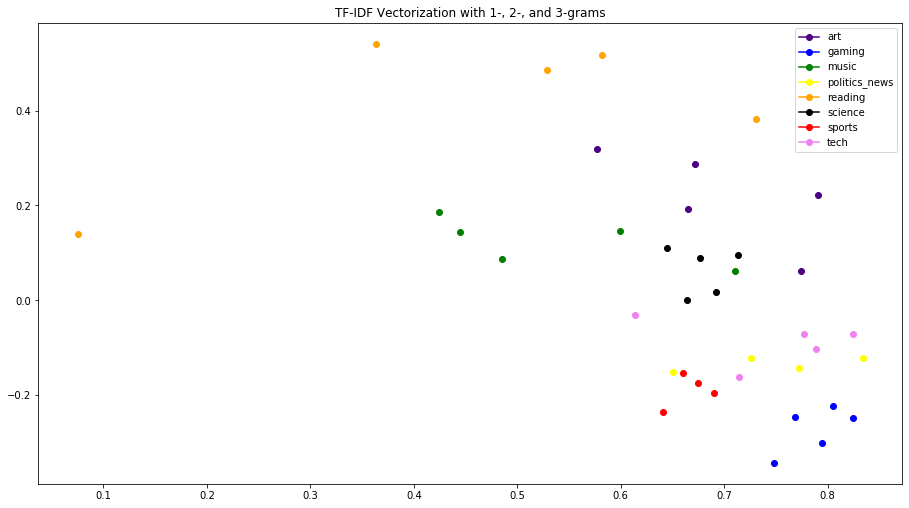

In [12]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-, 2-, and 3-grams')

**Count Vectorizer**

In [13]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'Count Vectorization with 1-grams')

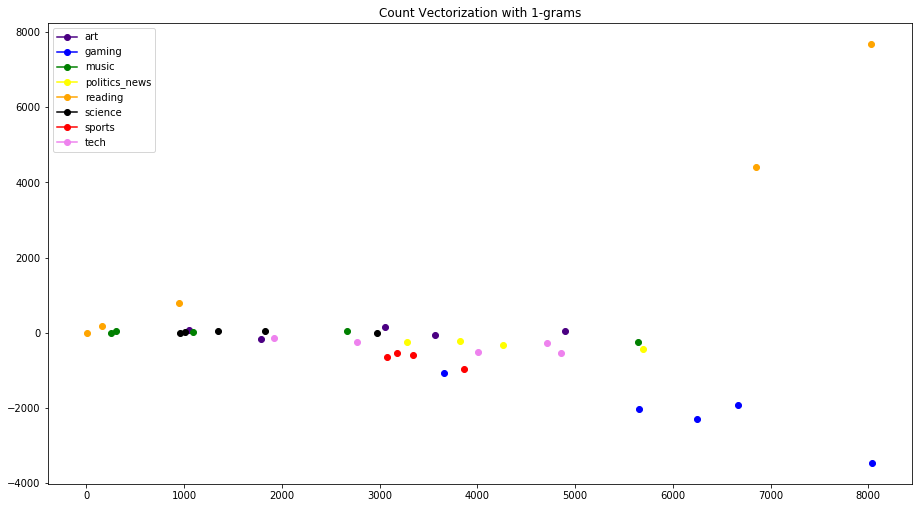

In [14]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1-grams')

Text(0.5, 1.0, 'Count Vectorization with 1- and 2-grams')

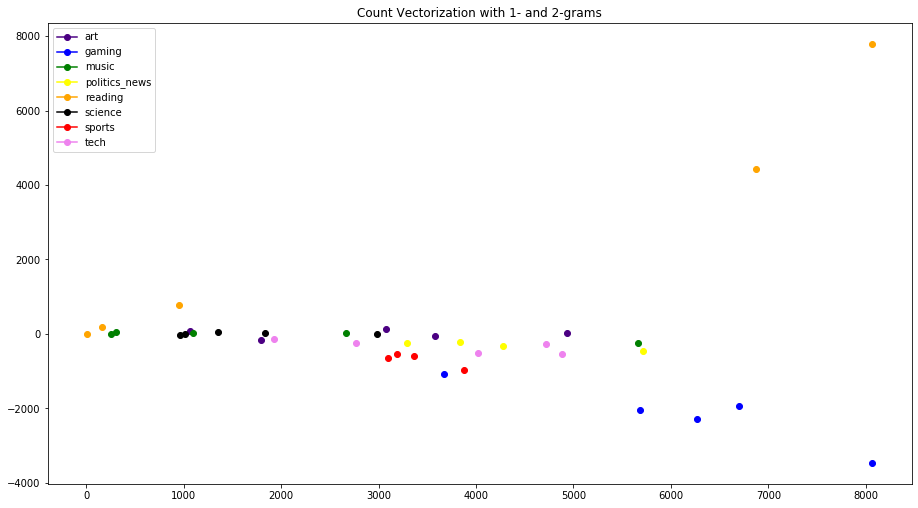

In [15]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1- and 2-grams')

Text(0.5, 1.0, 'Count Vectorization with 1-, 2-, and 3-grams')

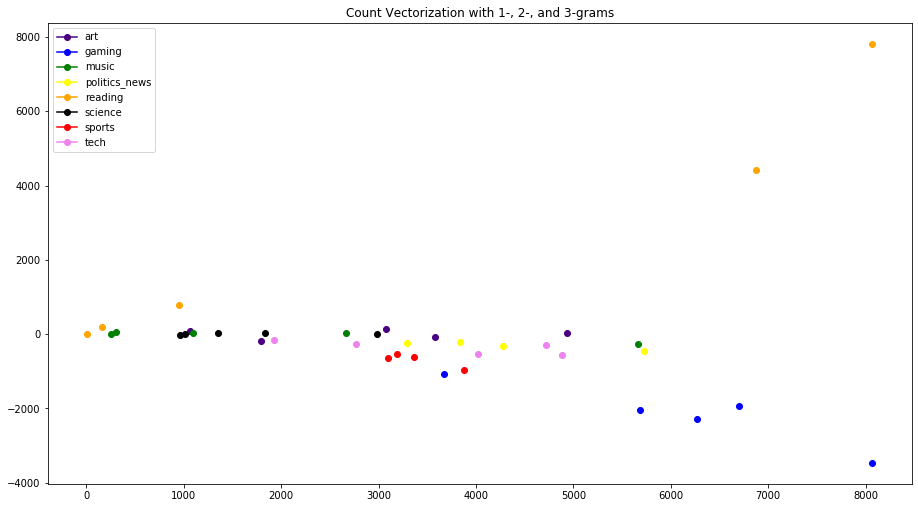

In [16]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1-, 2-, and 3-grams')

## Visualizing Word Embeddings

Let's read in our pre-trained document embeddings and visualize them:

In [2]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

Since reading subs aren't included in our document embeddings, let's go ahead and pop that out of our cats list:

In [9]:
cats.remove('reading')

In [12]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [13]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [18]:
os.chdir(r'C:\Users\jonat\Desktop\Data Mining\Project\Data')

model = Doc2Vec.load('subs.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)
labels = np.array(documents[:, 2], dtype=int)

Text(0.5, 1.0, 'Document Embeddings for Subreddits')

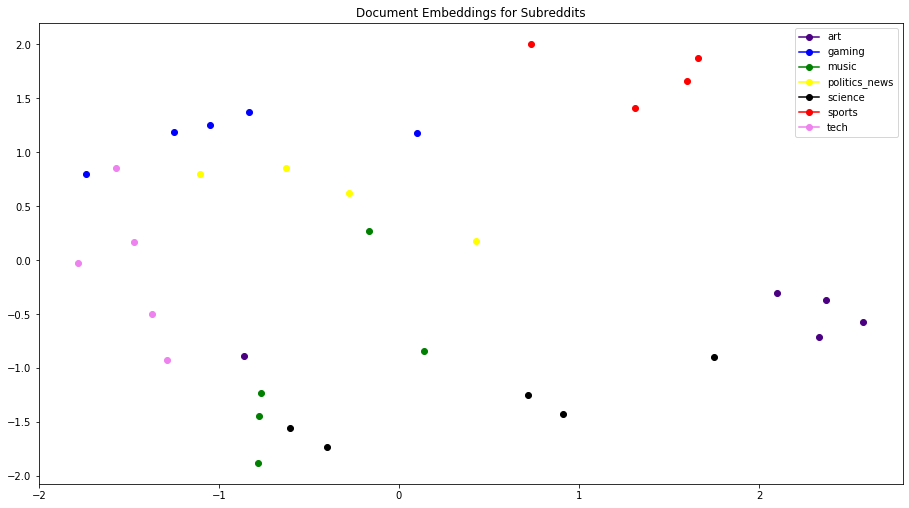

In [20]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Document Embeddings for Subreddits')

## Word Clouds

Another way to visualize text data is with word clouds:

In [17]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

**The art subreddits:**

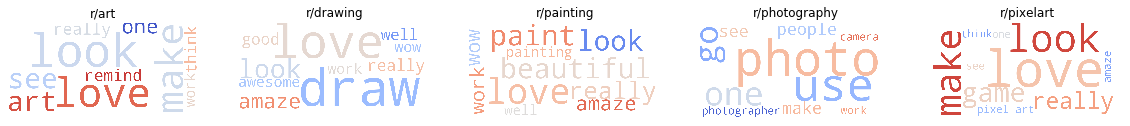

In [18]:
art_subs = documents[documents[:, 1] == 'art']

fig, ax = plt.subplots(ncols=len(art_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(art_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{art_subs[i][3]}')
    

**The gaming subreddits:**

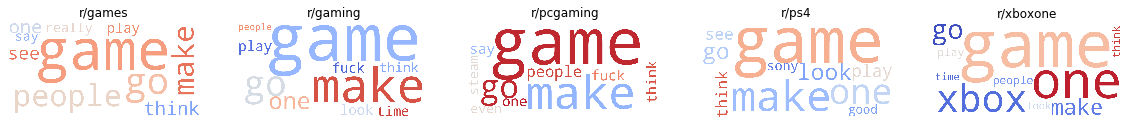

In [19]:
gaming_subs = documents[documents[:, 1] == 'gaming']

fig, ax = plt.subplots(ncols=len(gaming_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(gaming_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{gaming_subs[i][3]}')
    

**The music subreddits:**

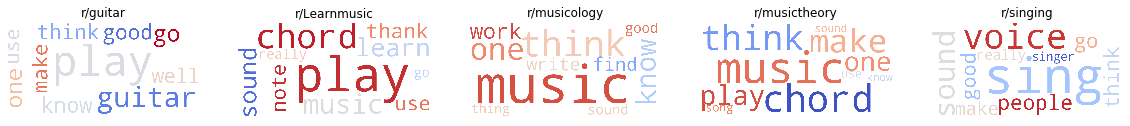

In [20]:
music_subs = documents[documents[:, 1] == 'music']

fig, ax = plt.subplots(ncols=len(music_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(music_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{music_subs[i][3]}')
    

**The politics/news subreddits:**

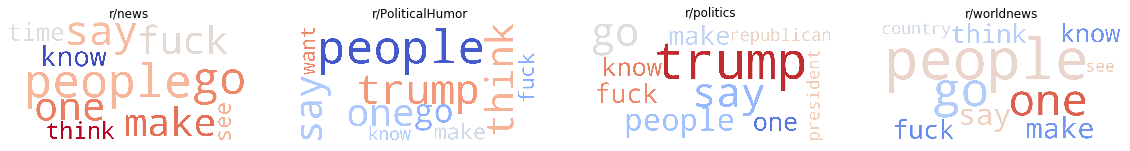

In [21]:
politics_news_subs = documents[documents[:, 1] == 'politics_news']

fig, ax = plt.subplots(ncols=len(politics_news_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(politics_news_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{politics_news_subs[i][3]}')

**The Reading subreddits:**

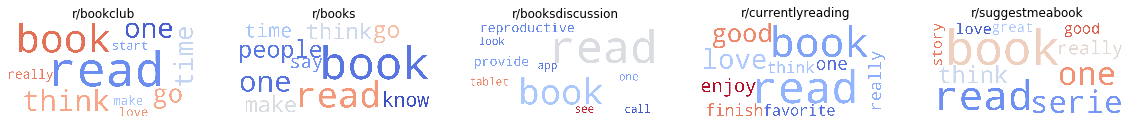

In [22]:
reading_subs = documents[documents[:, 1] == 'reading']

fig, ax = plt.subplots(ncols=len(reading_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(reading_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{reading_subs[i][3]}')

**The sports subreddits**:

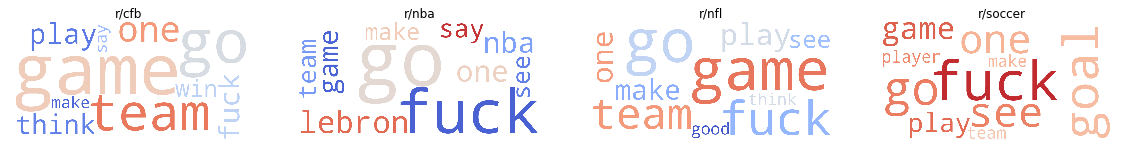

In [23]:
sports_subs = documents[documents[:, 1] == 'sports']

fig, ax = plt.subplots(ncols=len(sports_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(sports_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{sports_subs[i][3]}')

**The science subreddits:**

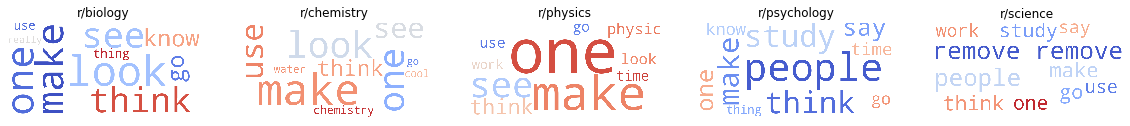

In [24]:
science_subs = documents[documents[:, 1] == 'science']

fig, ax = plt.subplots(ncols=len(science_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(science_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{science_subs[i][3]}')

**The tech subreddits**

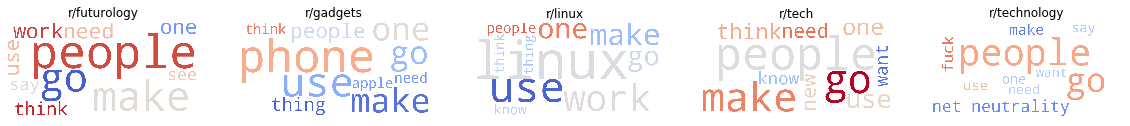

In [25]:
tech_subs = documents[documents[:, 1] == 'tech']

fig, ax = plt.subplots(ncols=len(tech_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(tech_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{tech_subs[i][3]}')

**You can use the script generate_visualizations.py to create all combinations of n-grams and stemming, as well as word clouds.**

## Exploring Posts

Finally, let's explore the text data grouped by post rather than subreddit:

In [26]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [27]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [28]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

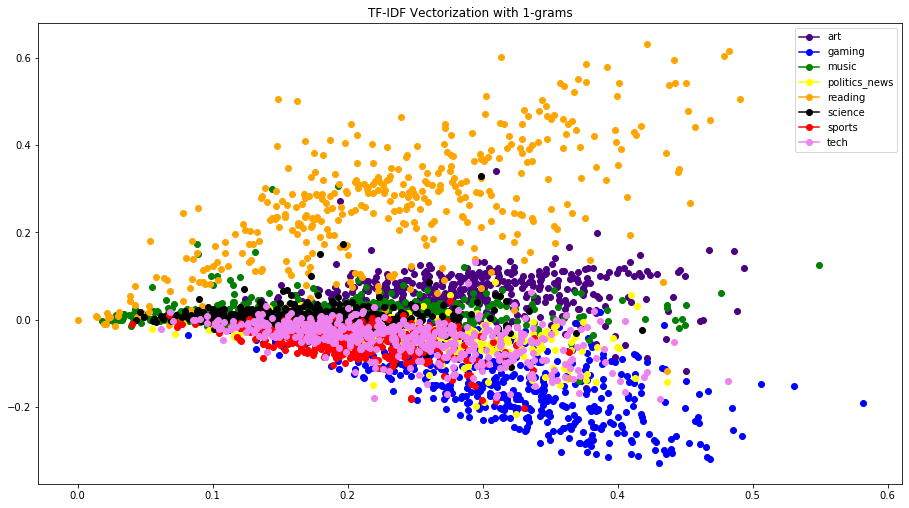

In [29]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

**Using document embeddings**

In [21]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [22]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [23]:
os.chdir(r'C:\Users\jonat\Desktop\Data Mining\Project\Data')

model = Doc2Vec.load('posts.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)

Text(0.5, 1.0, 'Document Embeddings for Subreddits')

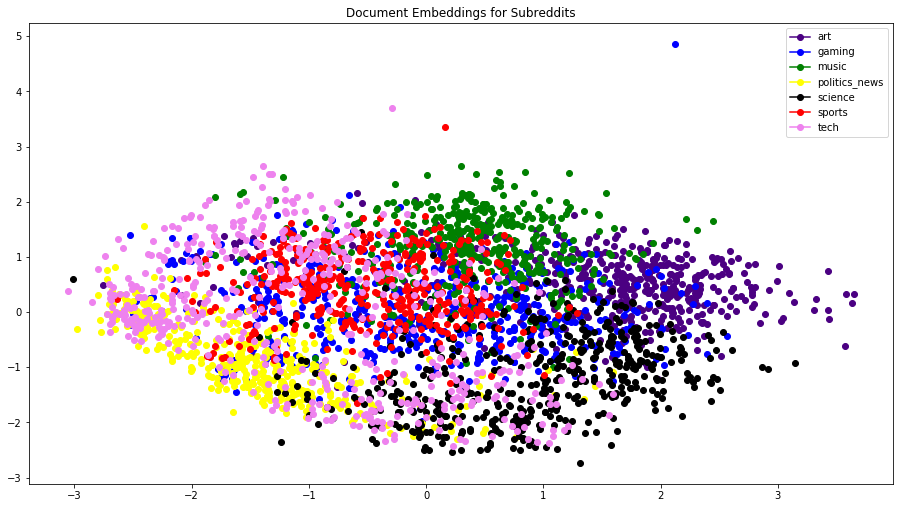

In [24]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Document Embeddings for Subreddits')

This will be harder to classify!  However, we should ask if the goal is to even classify by subreddit.  If we want to recommend posts, then getting correct topic classification might be worthwhile.  The logic there would be that posts in the same topic are more similar than posts in other topics.  We can measure the goodness of models produced this way with external measures: honogeneity, completeness, and v-measure.  These will measure the ability of our model to cluster posts into similar topics.